<img src="https://github.com/Sengsathit/OCR_data_scientist_assets/blob/main/header_olist.png?raw=true" alt="Alternative text" />

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
  - [Importations et configurations](#toc1_1_)    
- [Initialisation](#toc2_)    
  - [Chargement des données](#toc2_1_)    
  - [Sélection des features](#toc2_2_)    
- [Analyse des récences](#toc3_)    
- [Adjusted Rand Index](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

L'objectif de ce document est de simuler l'entraînement du modèle sur plusieurs périodes temporelles afin de déterminer la fréquence optimale de réentraînement nécessaire pour maintenir la performance du modèle de clustering.

## <a id='toc1_1_'></a>[Importations et configurations](#toc0_)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

# Configurer Pandas pour un affichage complet du contenu des colonnes
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = '#FFFCF7'    # Définir la couleur de fond de la figure
plt.rcParams['axes.facecolor'] = '#FFFCF7'      # Définir la couleur de fond des axes

# <a id='toc2_'></a>[Initialisation](#toc0_)

## <a id='toc2_1_'></a>[Chargement des données](#toc0_)

In [7]:
df = pd.read_csv('../datasets/olist_clusters.csv')

## <a id='toc2_2_'></a>[Sélection des features](#toc0_)

In [8]:
features = ['recency', 'frequency', 'monetary','satisfaction']

# <a id='toc3_'></a>[Analyse des récences](#toc0_)

La majorité des clients ont une récence comprise entre 0 et 300 jours, indiquant des achats relativement récents. Le nombre de clients diminue progressivement à mesure que la récence augmente au-delà de 300 jours, ceci suggère que moins de clients ont effectué des achats plus anciens. Cette distribution met en évidence un pic d'activité d'achat dans la période récente, avec une baisse significative pour les achats plus anciens.

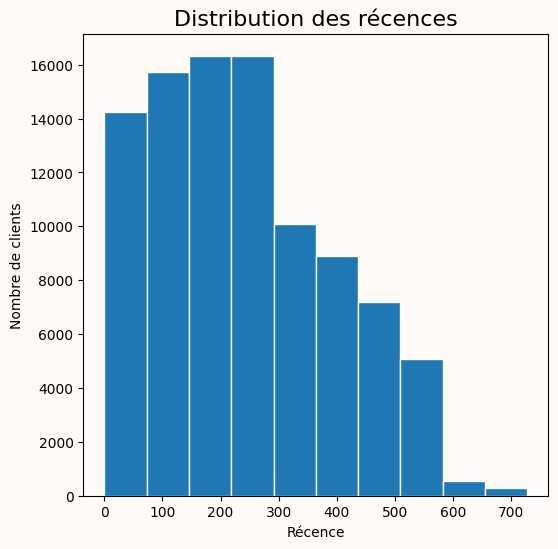

In [16]:
plt.figure(figsize=(6,6))
plt.hist(df['recency'], bins=10, edgecolor='white')
plt.xlabel('Récence')
plt.ylabel('Nombre de clients')
plt.title('Distribution des récences', fontsize=16)
plt.show()

# <a id='toc4_'></a>[Adjusted Rand Index](#toc0_)

L'ARI diminue de manière significative à mesure que la récence augmente, passant sous le seuil critique de 0,7 aux alentours de 100 jours. Cela suggère que le modèle de clustering perd en performance rapidement et nécessite des réentraînements fréquents, probablement tous les 100 jours, pour maintenir une performance optimale.

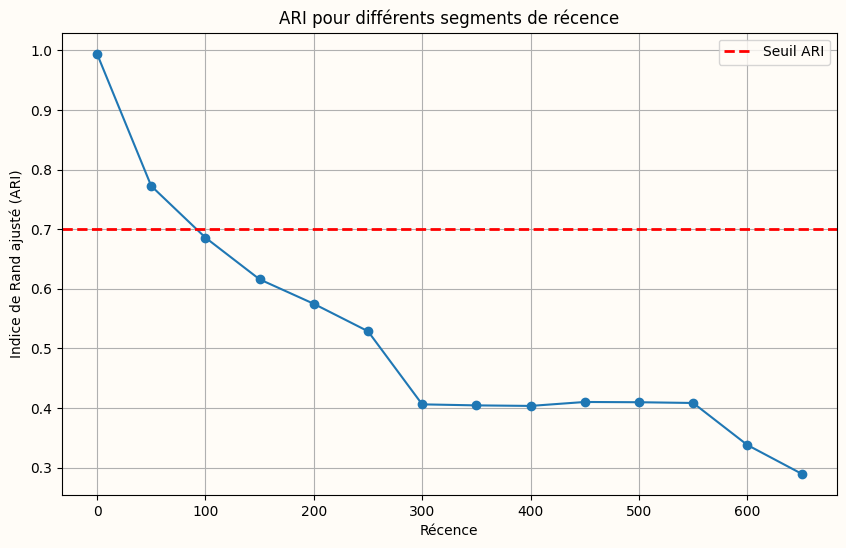

In [10]:
# Définir les paramètres
nb_jours = 50
k = 5
recency_segmentation_min = 0
recency_segmentation_max = 800

# Définir la segmentation temporelle à partir de la récence maximale
recency_segments = list(range(recency_segmentation_min, recency_segmentation_max, nb_jours))

# Initialiser les listes pour stocker les résultats
segments = []
aris = []

# Standardiser les données du dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[features])

# Boucle sur les segments
for segment in recency_segments:
    mask = (df['recency'] >= segment)
    segment_customer_ids = df.loc[mask, 'customer_unique_id']
    
    # Passer cette itération si les données du segment sont insuffisantes pour le clustering
    if len(segment_customer_ids) < k:
        continue

    # Segment standardisé
    segment_mask = df['customer_unique_id'].isin(segment_customer_ids)
    segment_data_scaled = data_scaled[segment_mask]

    # Adapter le modèle KMeans sur le segment
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(segment_data_scaled)

    # Prédire les clusters pour l'ensemble du dataset
    df['new_cluster_global'] = kmeans.predict(data_scaled)
    
    # Calculer l'indice de Rand ajusté pour l'ensemble du dataset
    ari = adjusted_rand_score(
        df['cluster'],
        df['new_cluster_global']
    )

    segments.append(segment)
    aris.append(ari)

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(segments, aris, marker='o')
plt.xlabel('Récence')
plt.ylabel('Indice de Rand ajusté (ARI)')
plt.title('ARI pour différents segments de récence')
plt.axhline(y=0.7, color='red', linestyle='--', linewidth=2, label='Seuil ARI')
plt.legend()
plt.grid()
plt.show()